In [45]:
import netCDF4 as nc
import numpy as np
import xarray as xr
import warnings
from eofs.xarray import Eof
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib import gridspec
import datetime
import seaborn as sns
import cmocean as cmo
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from scipy.stats import linregress
import matplotlib.patches as mpatches
import scipy.io as sio
import matplotlib.colors as mcolors
import matplotlib.patches as patch
import sys
import os
sys.path.append(os.path.abspath('../scripts'))
from mapping_utils import * 
from proj_utils import *

# Pull Velocity Data from AWS

### Set File Paths 

In [46]:
user_home_dir = expanduser('~')
fig_path      = '../figures'

### Pull Data (MONTHLY, NATIVE GRID)

In [7]:
s3, credentials = init_S3FileSystem(use_earthdata=False, requester_pays=True)
mzz_local_directory = Path('/efs_ecco/mzz-jsons-V4r5/MZZ_mon_mean_native')

#np.sort(list(mzz_local_directory.glob('*json')))

mzz_local_file= mzz_local_directory / 'OCEAN_VELOCITY_mon_mean_native_llc090_ECCOV4r5.json'

fs = fsspec.filesystem("reference",     
                       fo=str(mzz_local_file),
                       remote_protocol="s3",
                       remote_options={"anon":False, "requester_pays":True},
                       skip_instance_cache=True)
# 
fs.asynchronous = True
store = zarr.storage.FsspecStore(fs)
ds = xr.open_dataset(store, engine='zarr',
                     consolidated=False, chunks={'time':4, 'Z':50})

### Pull Bathy Data (NATIVE GRID)

In [60]:
bathy_path = user_home_dir + '/efs_ecco/ECCO/V4/r5/netcdf/native/geometry/GRID_GEOMETRY_ECCO_V4r5_native_llc0090.nc'
ds_bathy   = xr.open_dataset(bathy_path).Depth
ds_geom    = xr.open_dataset(bathy_path)

### Quickie Plot to Check

In [12]:
#ecco.plot_tiles(ds.VVEL[0,0,:,:,:], layout='latlon', 
#                rotate_to_latlon=True, 
#                show_tile_labels=True, 
#                show_colorbar=True, 
#                cmap=cmocean.cm.thermal,
#                cmin=-2,cmax=ds.VVEL[0,0,:,:,:].max().values);

### Subset North Atlantic (Tile = 10)

In [61]:
### -- TO DO: Add NA subset as routine (DONE) ### 
ds_na    = ds.isel(tile = 10)
ds_bathy = ds_bathy.isel(tile = 10)
ds_geom  = ds_geom.isel(tile = 10)

### Compute Velocity Mean for Plotting

In [14]:
ds_mean = ds_na.mean(dim = 'time').compute()

# Choose Transects

### Exploratory Plot to Select TGB Box Location: 

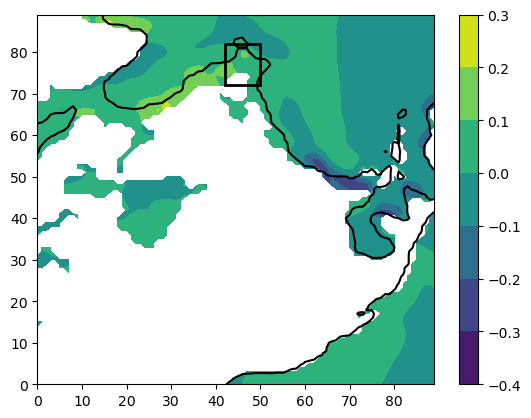

In [20]:
fig, ax = plt.subplots()
plt.contourf(ds_mean.i,ds_mean.j,ds_mean.UVEL[0,:,:])
plt.colorbar()
plt.contour(ds_bathy.i,ds_bathy.j,abs(ds_bathy),levels = [1000],colors = 'k')
ax.add_patch(patch.Rectangle((42,72),8,10,facecolor='None',edgecolor='k',linewidth=2))
#plt.scatter(np.repeat(ds_north_face.i,len(ds_north_face.j)),ds_north_face.j)

### Subset TGB 

In [63]:
ds_tgb = ds_na.sel(j = slice(71.75,84.25),i = slice(41.75,50.25),j_g = slice(71.75,84.25),i_g = slice(41.75,50.25))
ds_geom_north_face = ds_geom.sel(j = slice(71.75,84.25),i = slice(41.75,50.25),j_g = slice(71.75,84.25),i_g = slice(41.75,50.25))

In [64]:
# --- North/South Direction is i ---
ds_north_face = ds_tgb.sel(i = slice(ds_tgb.i[0]), i_g = slice(ds_tgb.i_g[0])).squeeze()
ds_geom_north_face = ds_geom_north_face.sel(i = slice(ds_tgb.i[0]), i_g = slice(ds_tgb.i_g[0])).squeeze()

### Plot mean and time dependent velocity sections

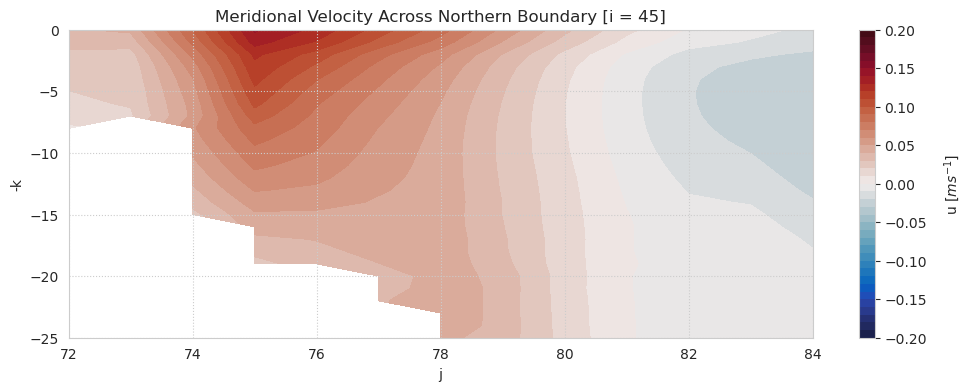

In [49]:
# --- Time Mean Velocity Across North Face ---
sv_name = '/north_face_uvel_mean'
sns.set_style('whitegrid',{"grid.linestyle": ":"})
plt.figure(figsize=[12,4])
levels = np.linspace(-0.4,0.4,41)
plt.contourf(ds_north_face.j,-ds_north_face.k,ds_north_face.UVEL.mean(dim = 'time'),cmap='cmo.balance',levels = levels,zorder = 0)

plt.title('Meridional Velocity Across Northern Boundary [i = 45]')
cbar = plt.colorbar()
cbar.set_label('u [$ms^{-1}$]',  labelpad=11)
plt.xlabel('j')
plt.ylabel('-k')
plt.ylim([-25, 0])
plt.savefig(fig_path + sv_name + '.png', format='png', bbox_inches="tight",dpi=500)

In [55]:
# --- Time Dependent Velocity Across North Face ---
for t in range(len(ds_north_face.time)):
    sv_name = '/north_face_uvel_' + str(ds_north_face.time[t].dt.year.data) + '_' + str(ds_north_face.time[t].dt.month.data).zfill(2)
    sns.set_style('whitegrid',{"grid.linestyle": ":"})
    plt.figure(figsize=[12,4])
    levels = np.linspace(-0.4,0.4,41)
    plt.contourf(ds_north_face.j,-ds_north_face.k,ds_north_face.UVEL[t,:,:],cmap='cmo.balance',levels = levels,zorder = 0)
    cbar = plt.colorbar()
    cbar.set_label('u [$ms^{-1}$]',  labelpad=11)
    plt.xlabel('j')
    plt.ylabel('-k')
    plt.ylim([-25, 0])
    plt.title('Velocity Normal to North Face: ' + str(ds_north_face.time[t].dt.year.data) + '-' + str(ds_north_face.time[t].dt.month.data).zfill(2),fontsize = 16)
    plt.savefig(fig_path + '/north_face_uvel_timesteps' + sv_name + '.png', format='png', bbox_inches="tight",dpi=500)
    plt.close()

In [56]:
import glob
import contextlib
from PIL import Image

fp_in = fig_path + '/north_face_uvel_timesteps/north_face_uvel_*.png'
fp_out = fig_path + '/north_face_uvel_timesteps_composite.gif'
with contextlib.ExitStack() as stack:
    imgs = (stack.enter_context(Image.open(f))
            for f in sorted(glob.glob(fp_in)))
    img = next(imgs)
    img.save(fp=fp_out, format='GIF', append_images=imgs,
             save_all=True, duration=200, loop=0)

# Make the Mask

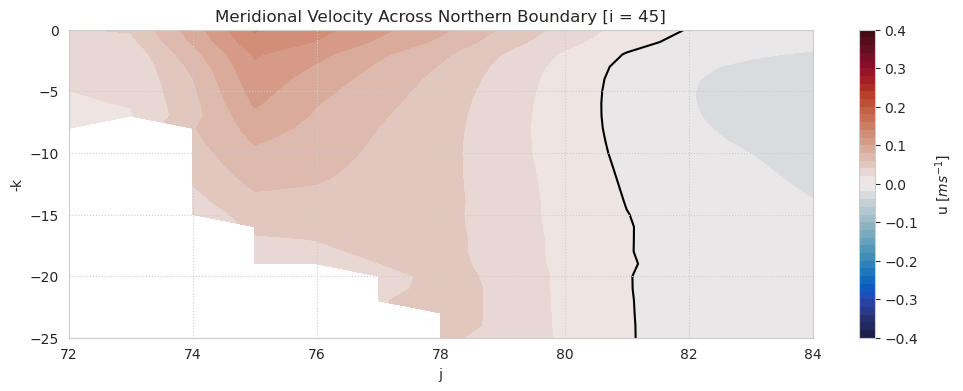

In [58]:
# Here the mask is going to be ones where the mean flow is southward (+), into the box, 
# and zeros everywhere else

# --- Time Mean Velocity Across North Face ---
# --- With Mask location --- 
sv_name = '/north_face_uvel_mean_with_mask_contour'
sns.set_style('whitegrid',{"grid.linestyle": ":"})
plt.figure(figsize=[12,4])
levels = np.linspace(-0.4,0.4,41)
plt.contourf(ds_north_face.j,-ds_north_face.k,ds_north_face.UVEL.mean(dim = 'time'),cmap='cmo.balance',levels = levels,zorder = 0)
plt.title('Meridional Velocity Across Northern Boundary [i = 45]')
cbar = plt.colorbar()
cbar.set_label('u [$ms^{-1}$]',  labelpad=11)
plt.contour(ds_north_face.j,-ds_north_face.k,ds_north_face.UVEL.mean(dim = 'time'),colors='k',levels = [0],zorder = 0)

plt.xlabel('j')
plt.ylabel('-k')
plt.ylim([-25, 0])
plt.savefig(fig_path + sv_name + '.png', format='png', bbox_inches="tight",dpi=500)

In [69]:
mask_da = ds_north_face.UVEL.mean(dim = 'time') >= 0

In [70]:
vels_masked    = ds_north_face.where(mask_da)
geom_masked    = ds_geom_north_face.where(mask_da)

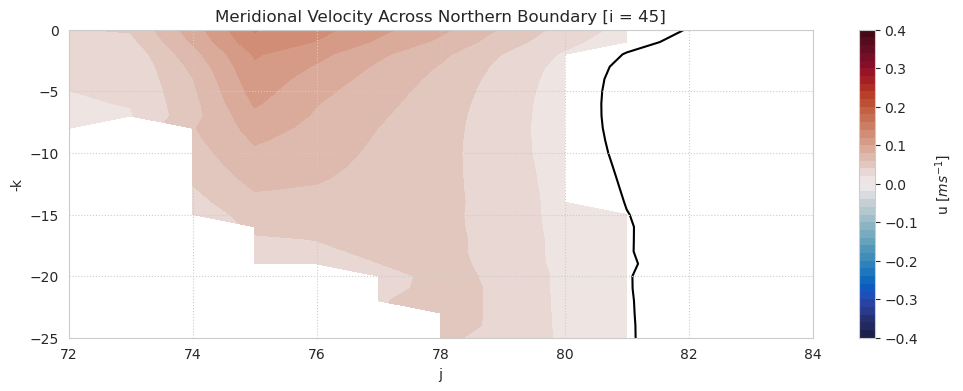

In [71]:
# --- Time Mean Velocity Across North Face ---
# --- With Only Southward Flow --- 
sv_name = '/north_face_uvel_mean_masked'
sns.set_style('whitegrid',{"grid.linestyle": ":"})
plt.figure(figsize=[12,4])
levels = np.linspace(-0.4,0.4,41)
plt.contourf(ds_north_face.j,-ds_north_face.k,vels_masked.UVEL.mean(dim = 'time'),cmap='cmo.balance',levels = levels,zorder = 0)
plt.title('Meridional Velocity Across Northern Boundary [i = 45]')
cbar = plt.colorbar()
cbar.set_label('u [$ms^{-1}$]',  labelpad=11)
plt.contour(ds_north_face.j,-ds_north_face.k,ds_north_face.UVEL.mean(dim = 'time'),colors='k',levels = [0],zorder = 0)

plt.xlabel('j')
plt.ylabel('-k')
plt.ylim([-25, 0])
plt.savefig(fig_path + sv_name + '.png', format='png', bbox_inches="tight",dpi=500)

# Save Mask

In [72]:
mask_da.to_net

<xarray.DataArray 'UVEL' (k: 50, j: 13)> Size: 650B
dask.array<ge, shape=(50, 13), dtype=bool, chunksize=(25, 13), chunktype=numpy.ndarray>
Coordinates:
    XC       (j) float32 52B dask.array<chunksize=(13,), meta=np.ndarray>
    YC       (j) float32 52B dask.array<chunksize=(13,), meta=np.ndarray>
    Z        (k) float32 200B dask.array<chunksize=(50,), meta=np.ndarray>
    i        int32 4B 42
    i_g      int32 4B 42
  * j        (j) int32 52B 72 73 74 75 76 77 78 79 80 81 82 83 84
  * k        (k) int32 200B 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49
    tile     int32 4B 10